In [1]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K
from keras.utils.image_utils import img_to_array, array_to_img, load_img
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Recall, Precision
from metrics import dice_loss, dice_coef, iou
import os
import cv2
import glob
import numpy as np
from PIL import Image, ImageOps
from skimage import color
from skimage import io
img = []
masks = []

In [2]:
def training_data():
    
    img_dir = './imgDeep' #orginal directory
    mask_dir = './newMasks' #augmented directory
    data_img_path = os.path.join(img_dir,'*g')
    data_mask_path = os.path.join(mask_dir,'*g')

    img_files = glob.glob(data_img_path) #error @ rgb_img when removing glob.glob dunno y
    mask_files = glob.glob(data_mask_path)
    data = []
    
    for f1 in img_files:
        orgImg = Image.open(f1).resize((512,512))
        mirImg = ImageOps.mirror(Image.open(f1).resize((512,512)))
        
        
        img.append(np.array(orgImg)) 
        img.append(np.array(mirImg))
      #  img.append(np.array(ImageOps.flip(orgImg)))
      #  img.append(np.array(ImageOps.flip(mirImg)))
        
    for f2 in mask_files:
        
        orgMask = Image.open(f2).resize((512,512))
        mirMask = ImageOps.mirror(Image.open(f2).resize((512,512)))
        
        masks.append(np.array(orgMask))
        masks.append(np.array(mirMask))
      #  masks.append(np.array(ImageOps.flip(orgMask)))
      #  masks.append(np.array(ImageOps.flip(mirMask)))
        
  
training_data()

In [3]:
img_np = np.array(img)
masks_np = np.array(masks)

In [4]:
print(img_np.shape, masks_np.shape)

(180, 512, 512, 3) (180, 512, 512, 4)


In [5]:
#masks_np = np.array(masks_np/255.0)
masksCV = []
imgCV = []

for f2 in masks_np:
   masksCV.append(cv2.cvtColor(f2, cv2.COLOR_BGR2GRAY))
    

#for f2 in img:
#    imgCV.append(Image.open(f2))

masksCV_np = np.array(masksCV)



In [6]:
print(img_np.shape, masksCV_np.shape)

(180, 512, 512, 3) (180, 512, 512)


In [7]:
print(img_np.shape, masksCV_np.shape)

(180, 512, 512, 3) (180, 512, 512)


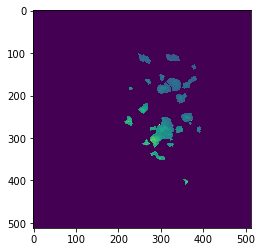

In [8]:
from matplotlib import pyplot as plt
plt.imshow(masksCV_np[0], interpolation='nearest')
plt.show()

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


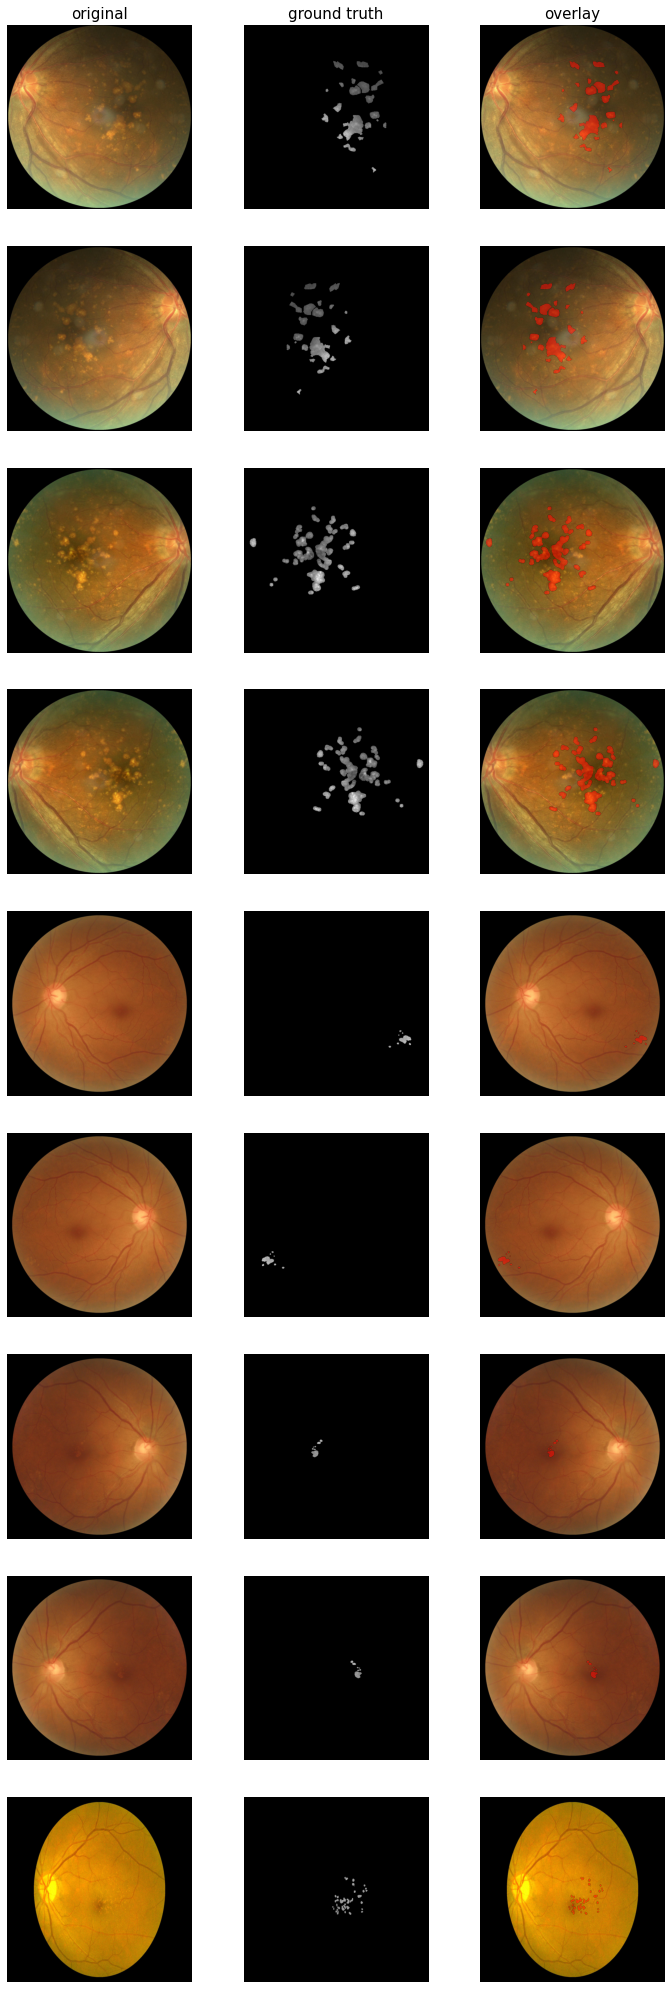

In [9]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=img_np, mask_imgs=masksCV_np, nm_img_to_plot=9, figsize=4)

In [10]:
print(img_np.max(), masksCV_np.max())

255 255


In [11]:
x = np.asarray(img_np, dtype=np.float32)/255
y = np.asarray(masksCV_np, dtype=np.float32)/255

In [12]:
print(x.max(), y.max())

1.0 1.0


In [13]:
print(x.shape, y.shape)

(180, 512, 512, 3) (180, 512, 512)


In [14]:
y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)
#x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
print(x.shape, y.shape)

(180, 512, 512, 3) (180, 512, 512, 1)


In [15]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (162, 512, 512, 3)
y_train:  (162, 512, 512, 1)
x_val:  (18, 512, 512, 3)
y_val:  (18, 512, 512, 1)


## Deeplab Implementation

In [16]:
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping, TensorBoard


DeepLab_model_filename = 'DeepLab_Model.h5'
callback_checkpoint = ModelCheckpoint(
    DeepLab_model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
),
ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
TensorBoard(),
EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),


(<keras.callbacks.EarlyStopping at 0x2c0f2707e80>,)

In [17]:
from model import deeplabv3_plus

In [18]:
deepLabModel = deeplabv3_plus((512, 512, 3))

In [19]:
deepLabModel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [20]:
from tensorflow import keras
loss = keras.losses.BinaryCrossentropy()
deepLabModel.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy", dice_coef, iou, Recall(), Precision()],
)

In [21]:
history = deepLabModel.fit(x=x_train, y=y_train, batch_size=2, epochs=20, validation_data=(x_val, y_val),
                           callbacks=[callback_checkpoint])

Epoch 1/20
81/81 [==============================] - ETA: 0s - loss: 0.0758 - accuracy: 0.9696 - dice_coef: 0.0215 - iou: 0.0109 - recall: 0.0127 - precision: 0.0189
Epoch 1: val_loss improved from inf to 0.22488, saving model to DeepLab_Model.h5
81/81 [==============================] - 491s 6s/step - loss: 0.0758 - accuracy: 0.9696 - dice_coef: 0.0215 - iou: 0.0109 - recall: 0.0127 - precision: 0.0189 - val_loss: 0.2249 - val_accuracy: 0.9828 - val_dice_coef: 9.1483e-13 - val_iou: 4.5742e-13 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/20
81/81 [==============================] - ETA: 0s - loss: 0.0326 - accuracy: 0.9815 - dice_coef: 0.0447 - iou: 0.0234 - recall: 0.0032 - precision: 0.3199
Epoch 2: val_loss improved from 0.22488 to 0.03896, saving model to DeepLab_Model.h5
81/81 [==============================] - 487s 6s/step - loss: 0.0326 - accuracy: 0.9815 - dice_coef: 0.0447 - iou: 0.0234 - recall: 0.0032 - precision: 0.3199 - val_loss: 0.0390 - val_accuracy: 0.9828

In [25]:
deepLabModel.load_weights(DeepLab_model_filename)
result = deepLabModel.predict(x_val)

1/1 [==============================] - 9s 9s/step


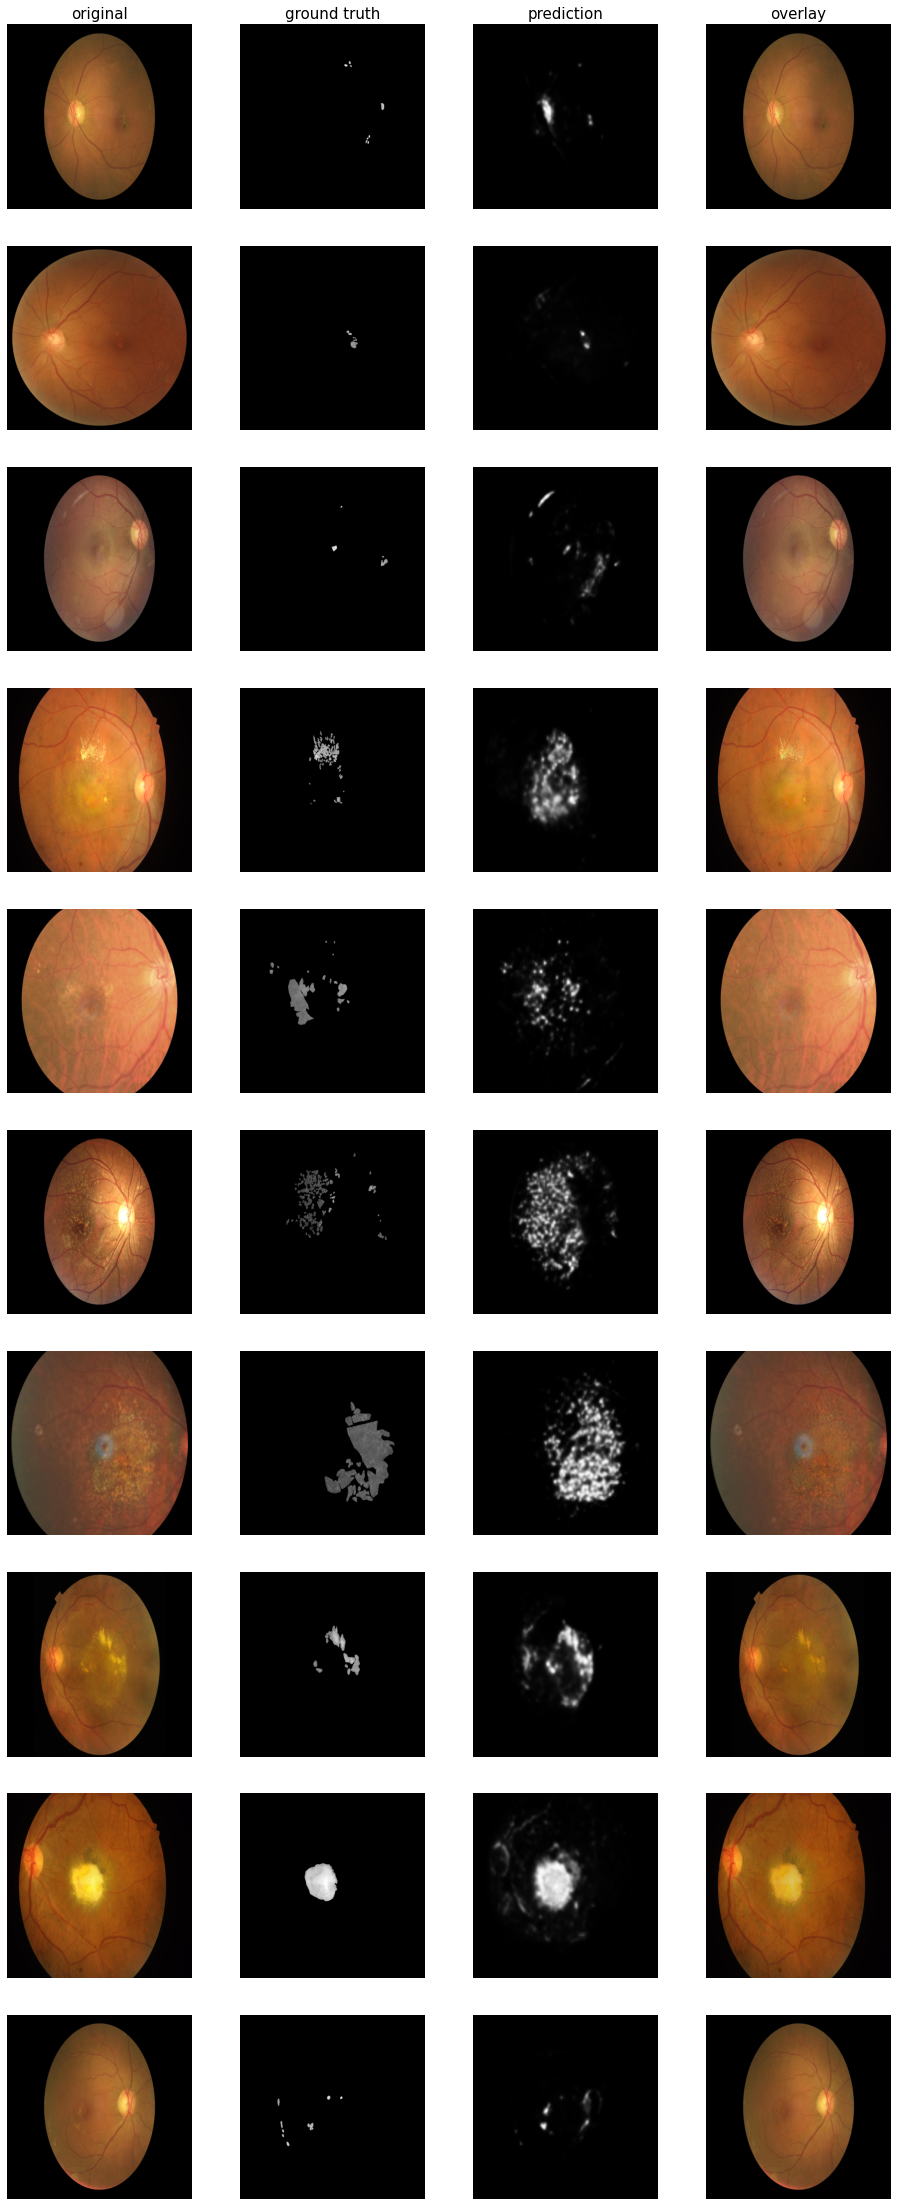

In [26]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=x_val, mask_imgs=y_val, pred_imgs=result, nm_img_to_plot=10)

## U Net Implementation


In [24]:
from keras_unet.models import custom_unet

input_shape = x_train[0].shape

model = custom_unet(
    input_shape,
    filters=32,
    use_batch_norm=True,
    dropout=0.3,
    dropout_change_per_layer=0.0,
    num_layers=4
)

model2 = Unet()

NameError: name 'Unet' is not defined

In [ ]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_29 (Conv2D)             (None, 512, 512, 32  320         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_30 (Conv2D)             (None, 512, 512, 32  9248        ['conv2d_29[0][0]']              
                                )                                                           

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 512, 512, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 512, 512, 32  128        ['conv2d_10[0][0]']              
 rmalization)                   )                                                           

In [ ]:
from keras.callbacks import ModelCheckpoint


model_filename = 'segm_model_v3.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)

In [ ]:
from keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[iou, iou_thresholded])

In [ ]:
if(os.path.exists(model_filename)):
    model.load_weights(model_filename)

print(os.path.exists(model_filename))

ValueError: Cannot assign value to variable ' conv2d_10/kernel:0': Shape mismatch.The variable shape (3, 3, 3, 32), and the assigned value shape (32, 1, 3, 3) are incompatible.

In [ ]:
model.fit(x=x_train, y=y_train, batch_size=5, epochs=25, validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint])

Epoch 1/25
65/65 [==============================] - ETA: 0s - loss: 0.0203 - iou: 0.1135 - iou_thresholded: 0.0703 
Epoch 1: val_loss improved from inf to 0.02077, saving model to segm_model_v3.h5
65/65 [==============================] - 679s 10s/step - loss: 0.0203 - iou: 0.1135 - iou_thresholded: 0.0703 - val_loss: 0.0208 - val_iou: 0.1162 - val_iou_thresholded: 0.0585
Epoch 2/25
65/65 [==============================] - ETA: 0s - loss: 0.0204 - iou: 0.1117 - iou_thresholded: 0.0641
Epoch 2: val_loss improved from 0.02077 to 0.02065, saving model to segm_model_v3.h5
65/65 [==============================] - 660s 10s/step - loss: 0.0204 - iou: 0.1117 - iou_thresholded: 0.0641 - val_loss: 0.0207 - val_iou: 0.1222 - val_iou_thresholded: 0.0787
Epoch 3/25
65/65 [==============================] - ETA: 0s - loss: 0.0206 - iou: 0.1114 - iou_thresholded: 0.0621 
Epoch 3: val_loss did not improve from 0.02065
65/65 [==============================] - 702s 11s/step - loss: 0.0206 - iou: 0.1114 - 

KeyboardInterrupt: 

In [ ]:
model.load_weights(model_filename)
y_pred = model.predict(x_val)

2/2 [==============================] - 19s 2s/step


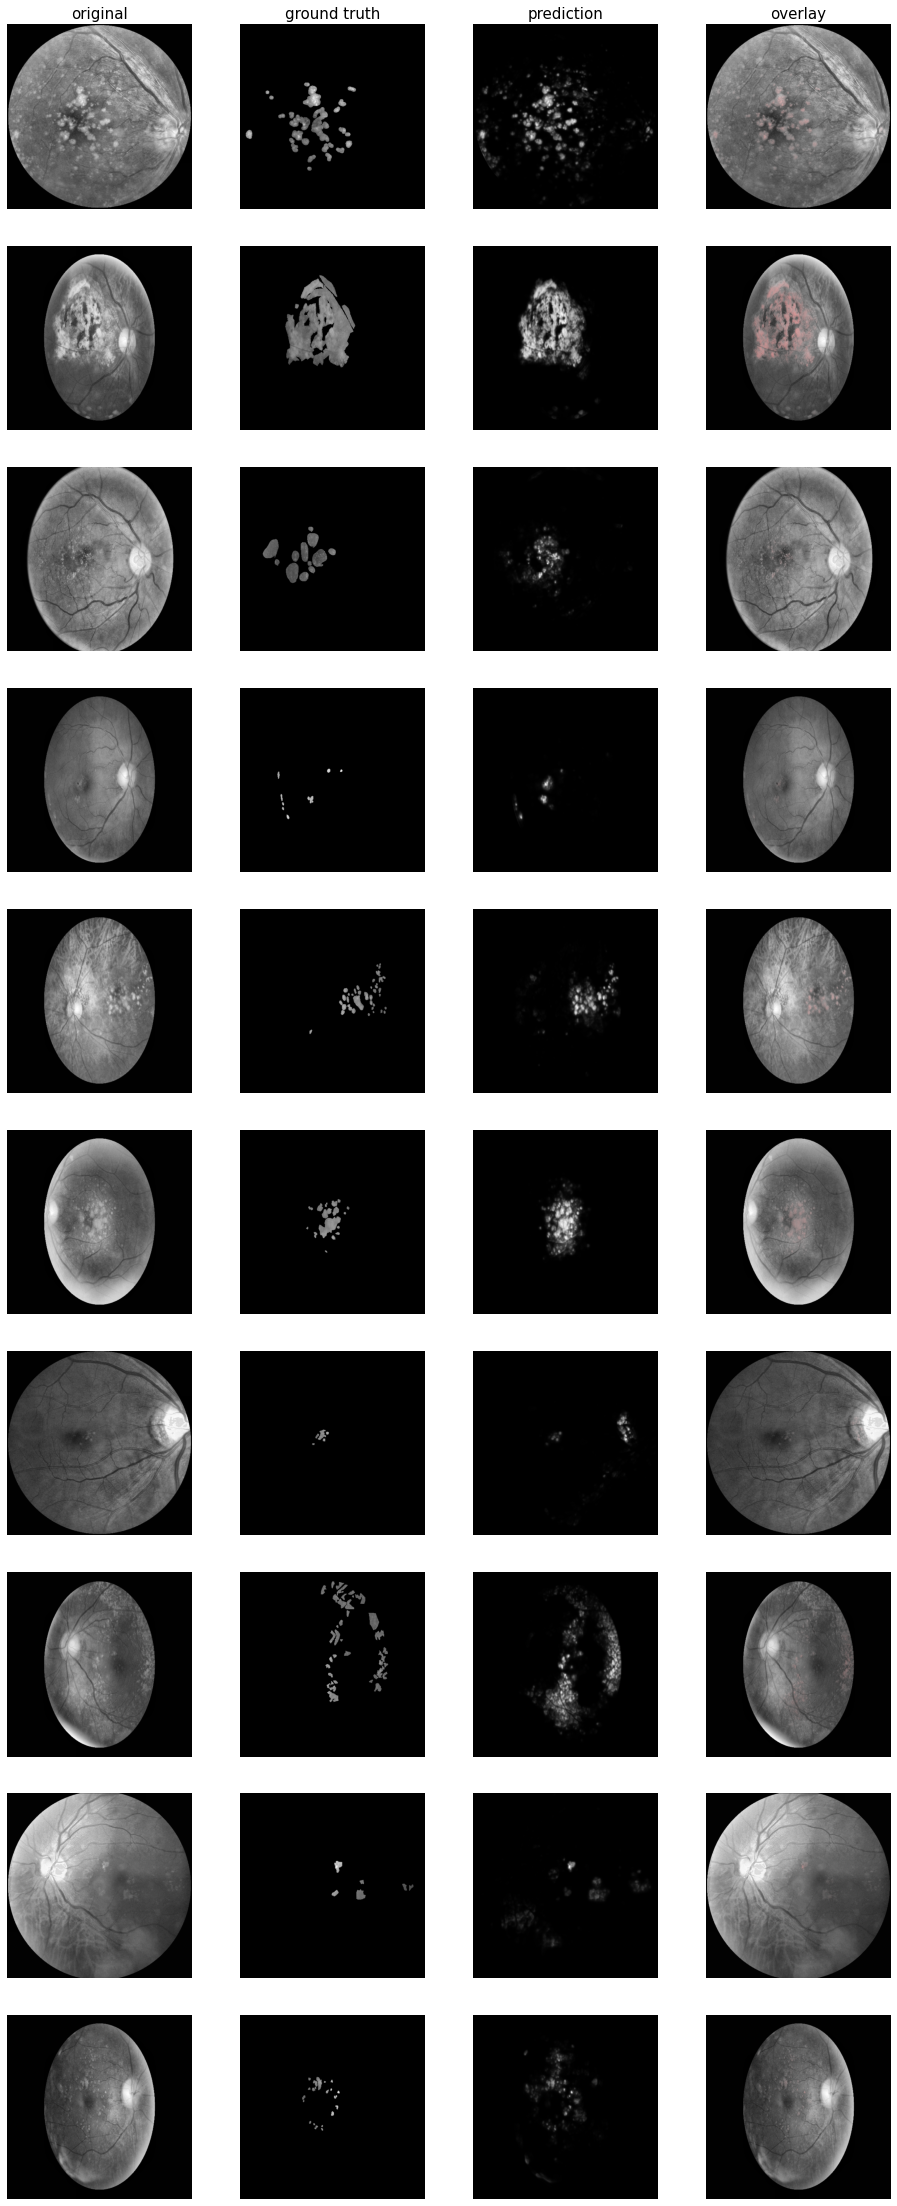

In [ ]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=x_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)

## Implementation to random data

In [ ]:
testing_img_dir = './testingFolder' #orginal directory
testing_data_img_path = os.path.join(testing_img_dir,'*g')
testing_img_files = glob.glob(testing_data_img_path)
testingImg = []

for f1 in testing_img_files:
        testingImg.append(np.array(Image.open(f1).resize((512,512))))


In [ ]:
testingImg = np.array(testingImg)

In [ ]:
testingImg.shape

(10, 512, 512)

In [ ]:
testingImg = testingImg.reshape(testingImg.shape[0], testingImg.shape[1], testingImg.shape[2],1)

In [ ]:
model_filename = 'segm_model_v3.h5'
model.load_weights(model_filename)
prediction = model.predict(testingImg)

1/1 [==============================] - 6s 6s/step


In [ ]:
#import tensorflow as tf
#for i, image in enumerate(prediction, 1):
#    tf.keras.preprocessing.image.save_img(f'my_picture_{i}.png', image)

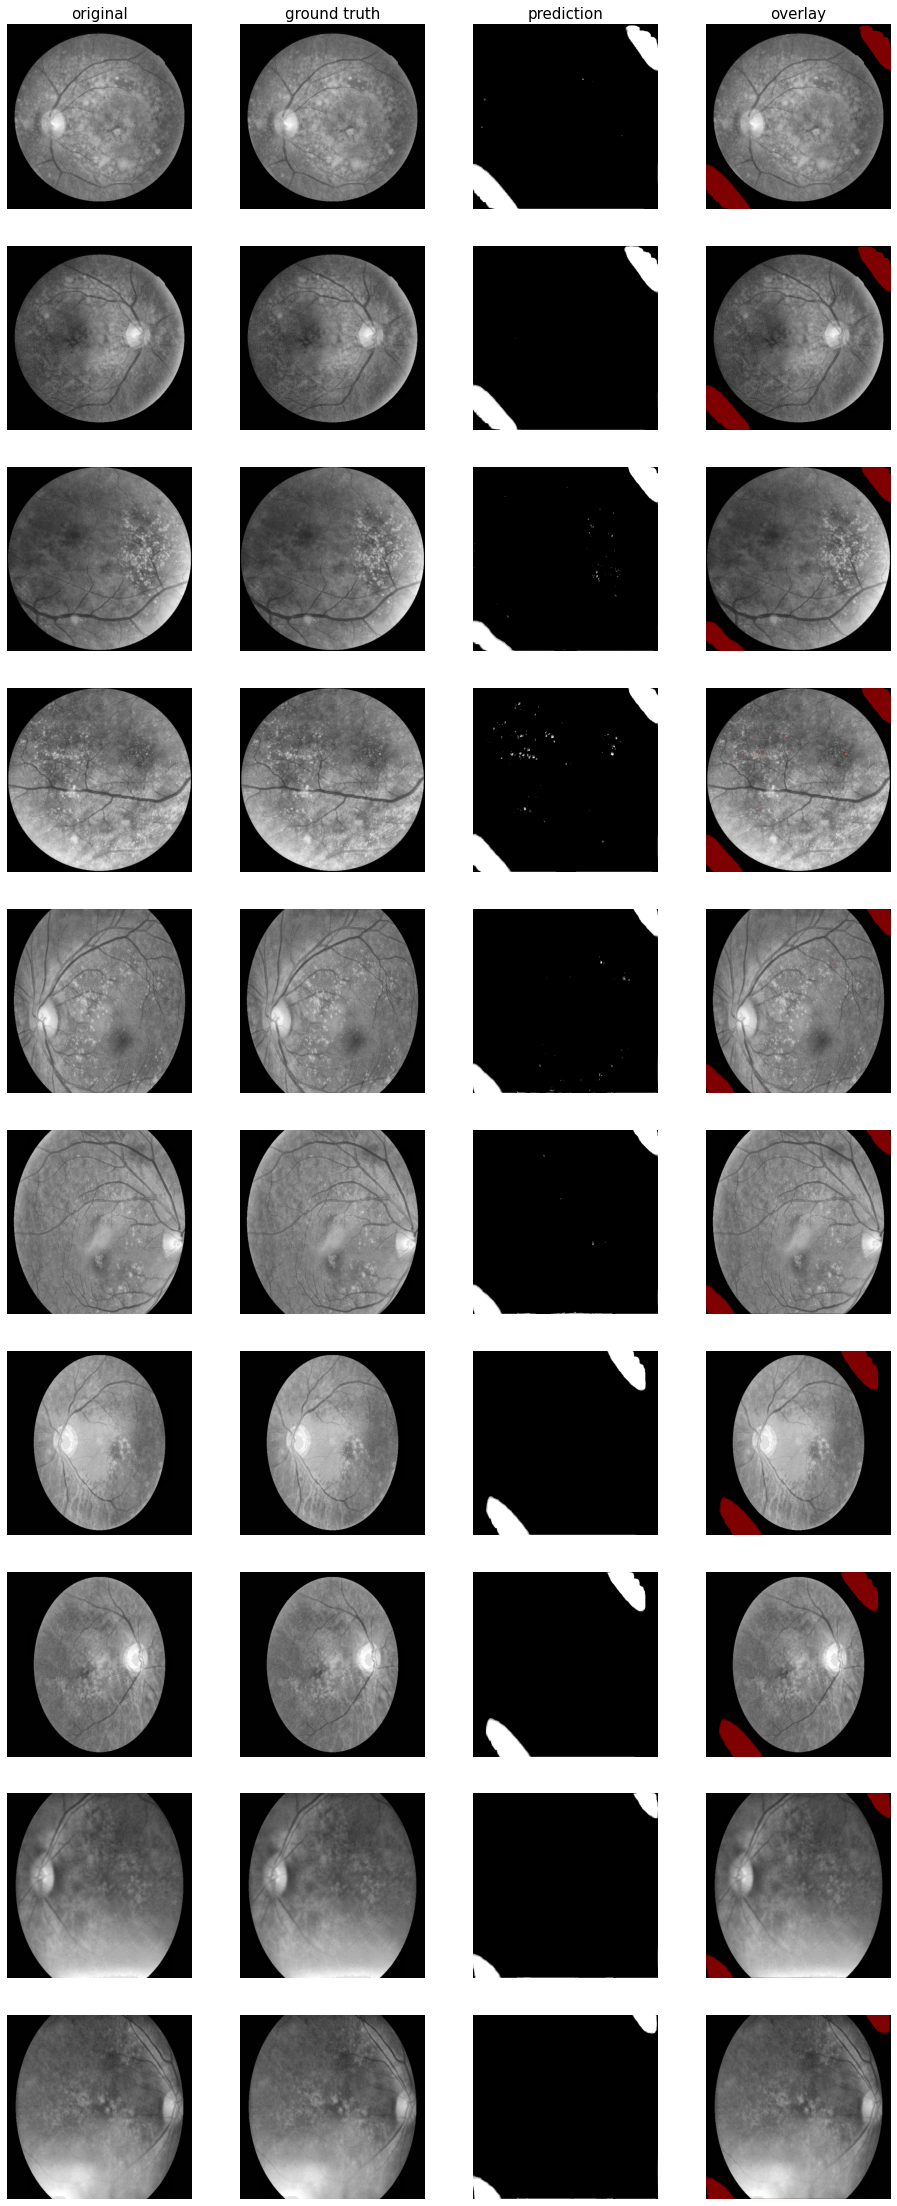

In [ ]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=testingImg, mask_imgs=testingImg, pred_imgs=prediction, nm_img_to_plot=10)